# Closed Vocabulary Analysis

### Import Packages

In [1]:
import pandas as pd
import re
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType
import re
from pyspark.sql import Window


In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("ClosedVocab").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/07/25 07:25:59 WARN Utils: Your hostname, Ryans-MacBook-Pro.local, resolves to a loopback address: 127.0.0.1; using 172.20.10.2 instead (on interface en0)
25/07/25 07:25:59 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/25 07:25:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/07/25 07:25:59 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


### Read in data

In [3]:
awards_data_cleaned = spark.read \
    .option("header", True) \
    .option("multiLine", True) \
    .option("quote", '"') \
    .option("escape", '"') \
    .option("delimiter", ",") \
    .csv("awards_data_cleaned.csv")

### List of Banned Words

Got the list from this link: https://www.nytimes.com/interactive/2025/03/07/us/trump-federal-agencies-websites-words-dei.html

In [4]:
banned_words = [
#A
    "accessible", "activism", "activists", "advocacy", "advocate", "advocates", "affirming care", "all-inclusive",
    "allyship", "anti-racism", "antiracist", "assigned at birth", "assigned female at birth", "assigned male at birth",
    "at risk", 
#B
    "barrier", "barriers", "belong", "bias", "biased", "biased toward", "biases", "biases towards",
    "biologically female", "biologically male", "BIPOC", "Black", "breastfeed + people", "breastfeed + person",
#C
    "chestfeed + people", "chestfeed + person", "clean energy", "climate crisis", "climate science",
    "commercial sex worker", "community diversity", "community equity", "confirmation bias", "cultural competence",
    "cultural differences", "cultural heritage", "cultural sensitivity", "culturally appropriate", "culturally responsive",
#D
    "DEI", "DEIA", "DEIAB", "DEIJ", "disabilities", "disability", "discriminated", "discrimination", "discriminatory",
    "disparity", "diverse", "diverse backgrounds", "diverse communities", "diverse community", "diverse group",
    "diverse groups", "diversified", "diversify", "diversifying", "diversity", 
#E    
    "enhance the diversity",
    "enhancing diversity", "environmental quality", "equal opportunity", "equality", "equitable", "equitableness", "equity",
    "ethnicity", "excluded", "exclusion", "expression", 
#F    
    "female", "females", "feminism", "fostering inclusivity", 
#G    
    "GBV", "gender", "gender based", "gender based violence", "gender diversity", "gender identity", "gender ideology",
    "gender-affirming care", "genders", "Gulf of Mexico",
#H    
    "hate speech", "health disparity", "health equity",
    "hispanic minority", "historically", 
#I    
    "identity", "immigrants", "implicit bias", "implicit biases", "inclusion",
    "inclusive", "inclusive leadership", "inclusiveness", "inclusivity", "increase diversity", "increase the diversity",
    "indigenous community", "inequalities", "inequality", "inequitable", "inequities", "inequity", "injustice",
    "institutional", "intersectional", "intersectionality", 
    
    "key groups", "key people", "key populations", 
    
    "Latinx", "LGBT", "LGBTQ", "marginalize", 
    
    "marginalized", "men who have sex with men", "mental health", "minorities", "minority",
    "most risk", "MSM", "multicultural", "Mx",
    
    "Native American", "non-binary", "nonbinary", "oppression", "oppressive",
    "orientation", "people + uterus", "people-centered care", "person-centered", "person-centered care", "polarization",
    "political", "pollution", "pregnant people", "pregnant person", "pregnant persons", "prejudice", "privilege",
    "privileges", "promote diversity", "promoting diversity", "pronoun", "pronouns", "prostitute", 
    
    "race", "race and ethnicity", "racial", "racial diversity", "racial identity", "racial inequality", "racial justice",
    "racially", "racism",
    
    "segregation", "sense of belonging", "sex", "sexual preferences", "sexuality", "social justice",
    "sociocultural", "socioeconomic", "status", "stereotype", "stereotypes", "systemic", "systemically", 
    
    "they/them",  "trans", "transgender", "transsexual", "trauma", "traumatic", "tribal", 
    
    "unconscious bias", "underappreciated", "underprivileged", "underrepresentation", "underrepresented", "underserved", "undervalued", 
    
    "victim", "victims", "vulnerable populations", 

    "women", "women and underrepresented"
]


In [6]:
len(banned_words)

197

In [5]:
from pyspark.sql import functions as F
import pandas as pd

# Step 1: Lowercase abstracts
awards_data_cleaned = awards_data_cleaned.withColumn("Abstract", F.lower(F.col("Abstract")))

# Step 2: Split abstracts into words
tokenized = awards_data_cleaned.withColumn("word", F.explode(F.split("Abstract", r"\s+")))


# Step 4: Filter only banned words
filtered = tokenized.filter(F.col("word").isin([w.lower() for w in banned_words]))

# Step 5: Count frequency per word per year
counts = filtered.groupBy("Year", "word").count()

# Step 6: Collect to Pandas and pivot
result_pd = counts.withColumnRenamed("word", "Word").withColumnRenamed("count", "Count").toPandas()
pivot_table = result_pd.pivot(index="Word", columns="Year", values="Count").fillna(0).astype(int)

pivot_table



Year,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
Word,,,,,,,,,,
accessible,297,177,232,240,243,299,297,324,333,442
activism,6,12,2,2,1,2,1,1,0,0
activists,2,0,0,0,0,0,0,0,0,0
advocacy,17,18,10,12,8,13,15,11,11,3
advocate,31,23,30,27,25,25,18,29,25,5
...,...,...,...,...,...,...,...,...,...,...
underrepresented,1167,1180,1232,1544,1440,1339,1534,1399,1092,165
underserved,77,69,79,110,121,120,141,148,152,24
undervalued,0,0,1,0,0,1,0,0,0,0


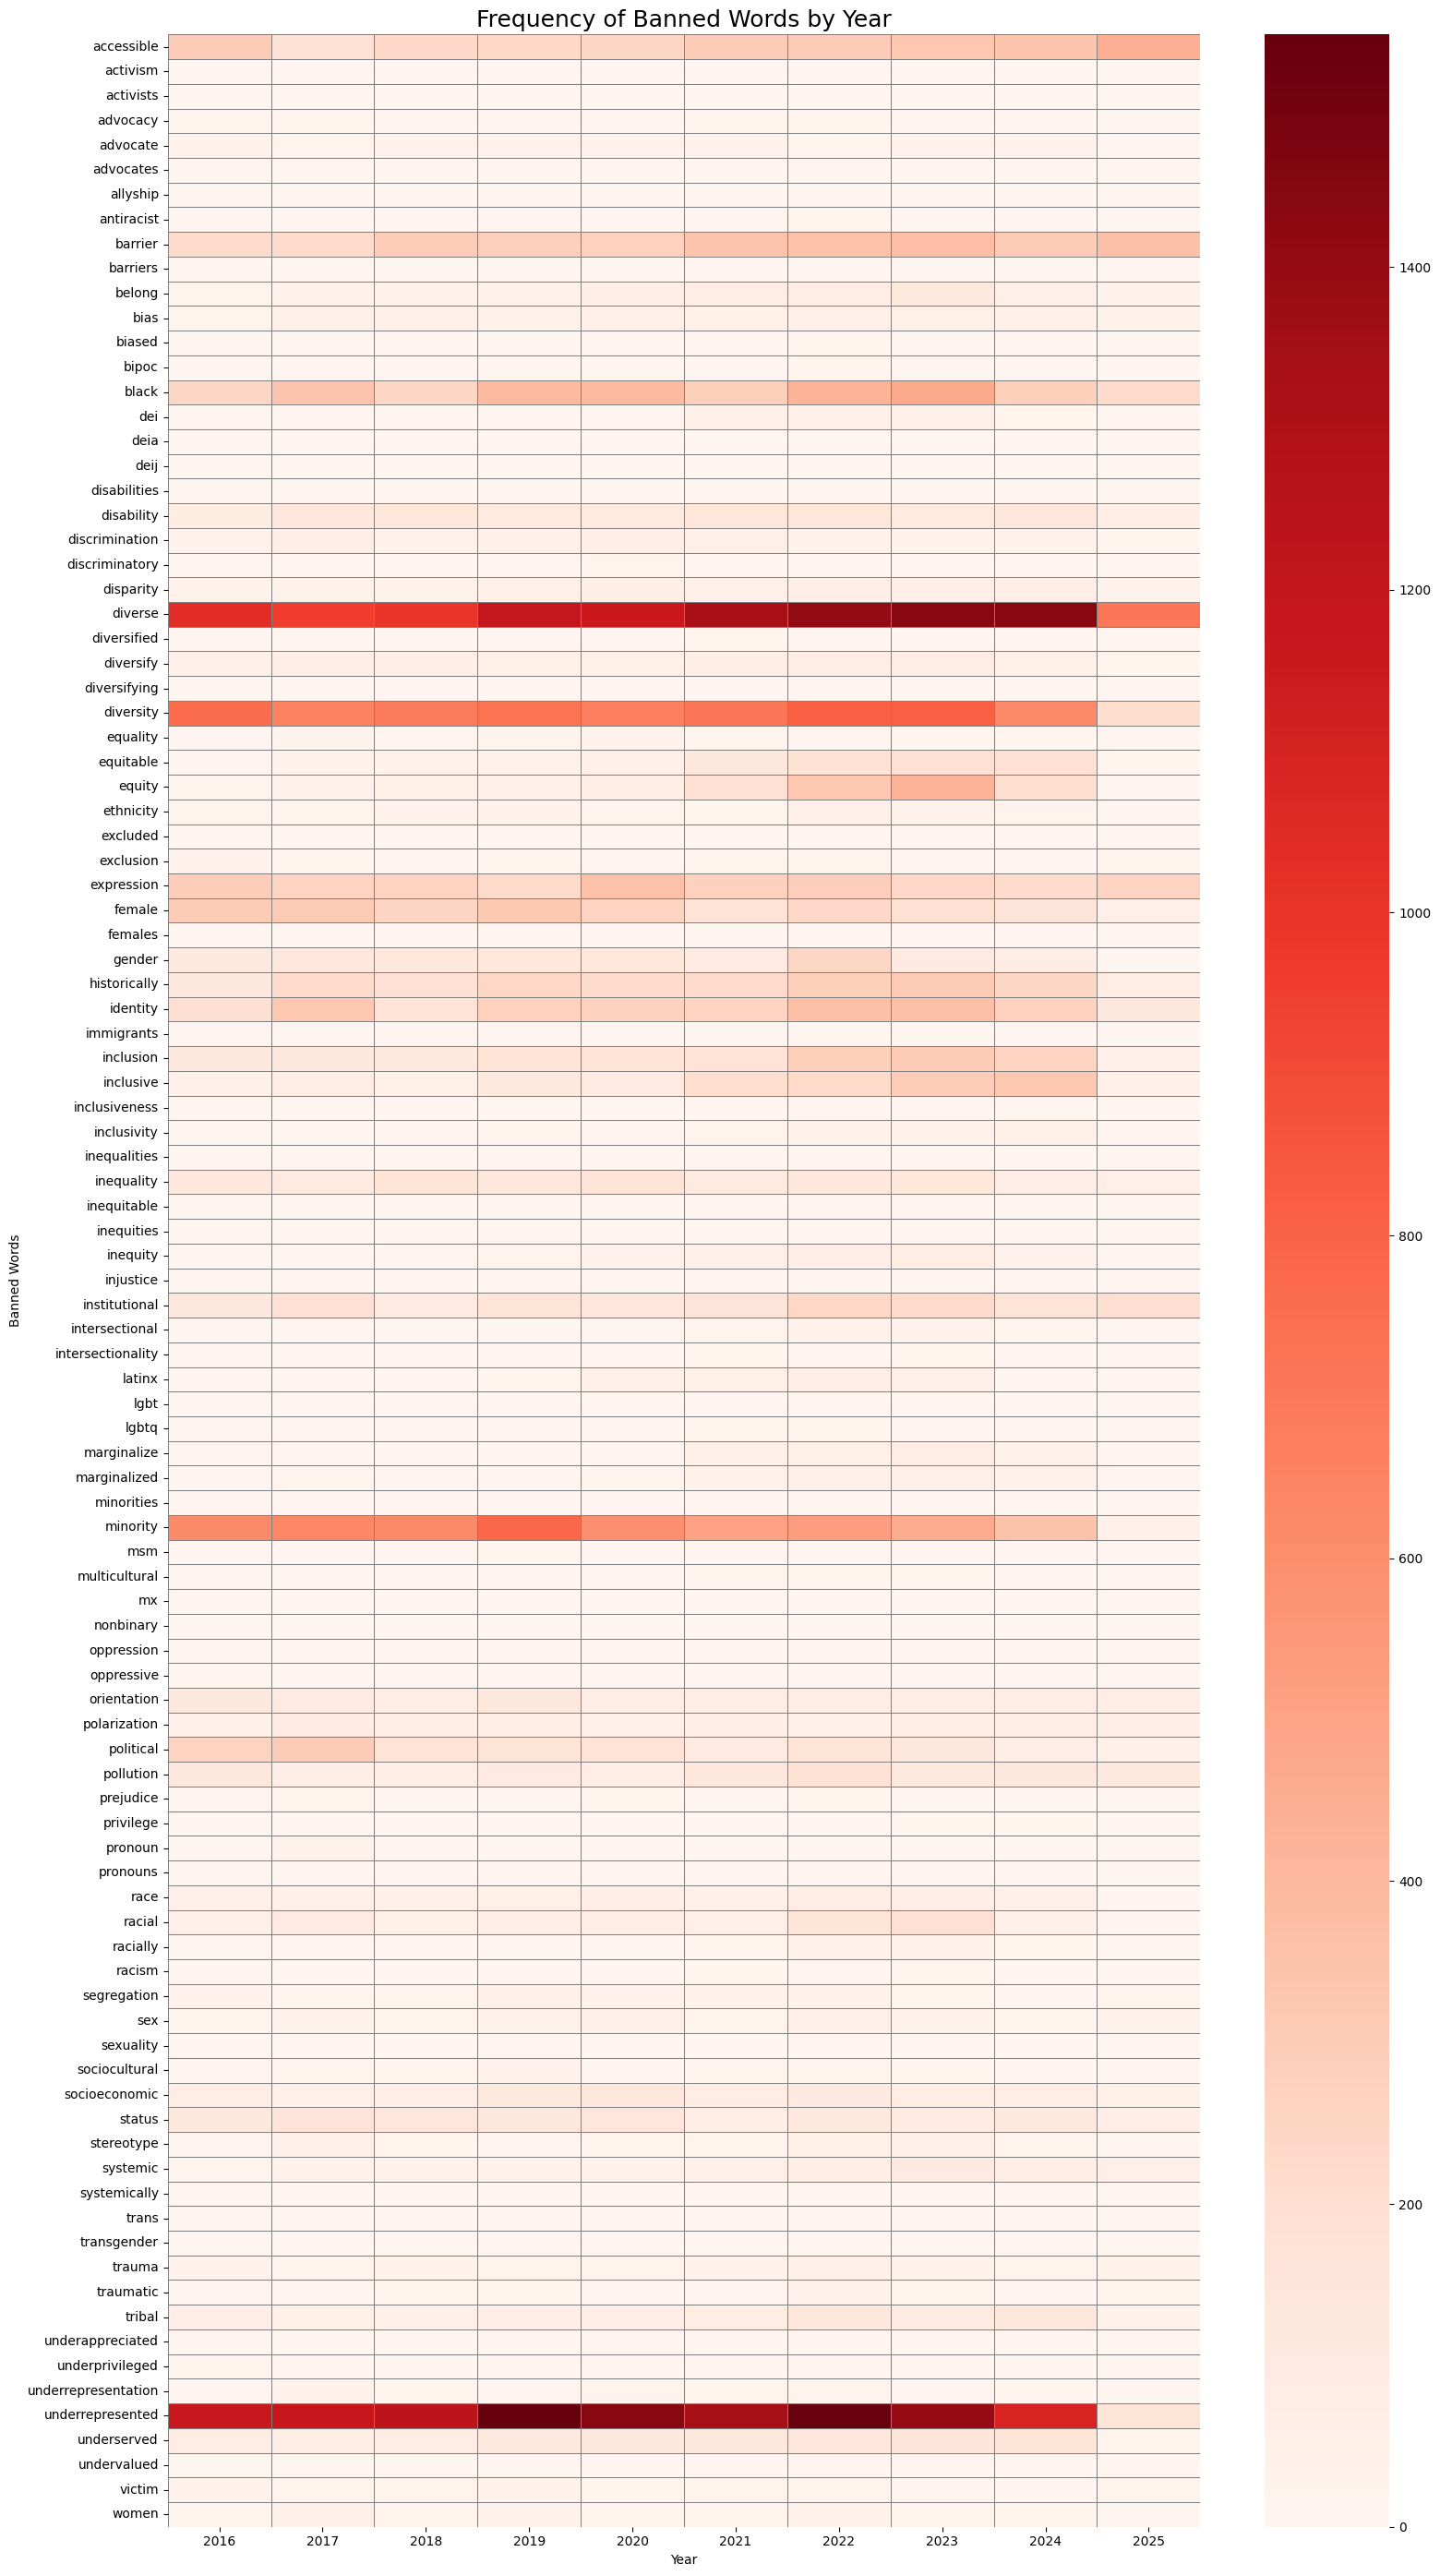

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 28))  # Adjust height for 197 rows
sns.heatmap(pivot_table, cmap="Reds", linewidths=0.5, linecolor='gray')

plt.title("Frequency of Banned Words by Year", fontsize=18)
plt.xlabel("Year")
plt.ylabel("Banned Words")
plt.tight_layout()
plt.show()

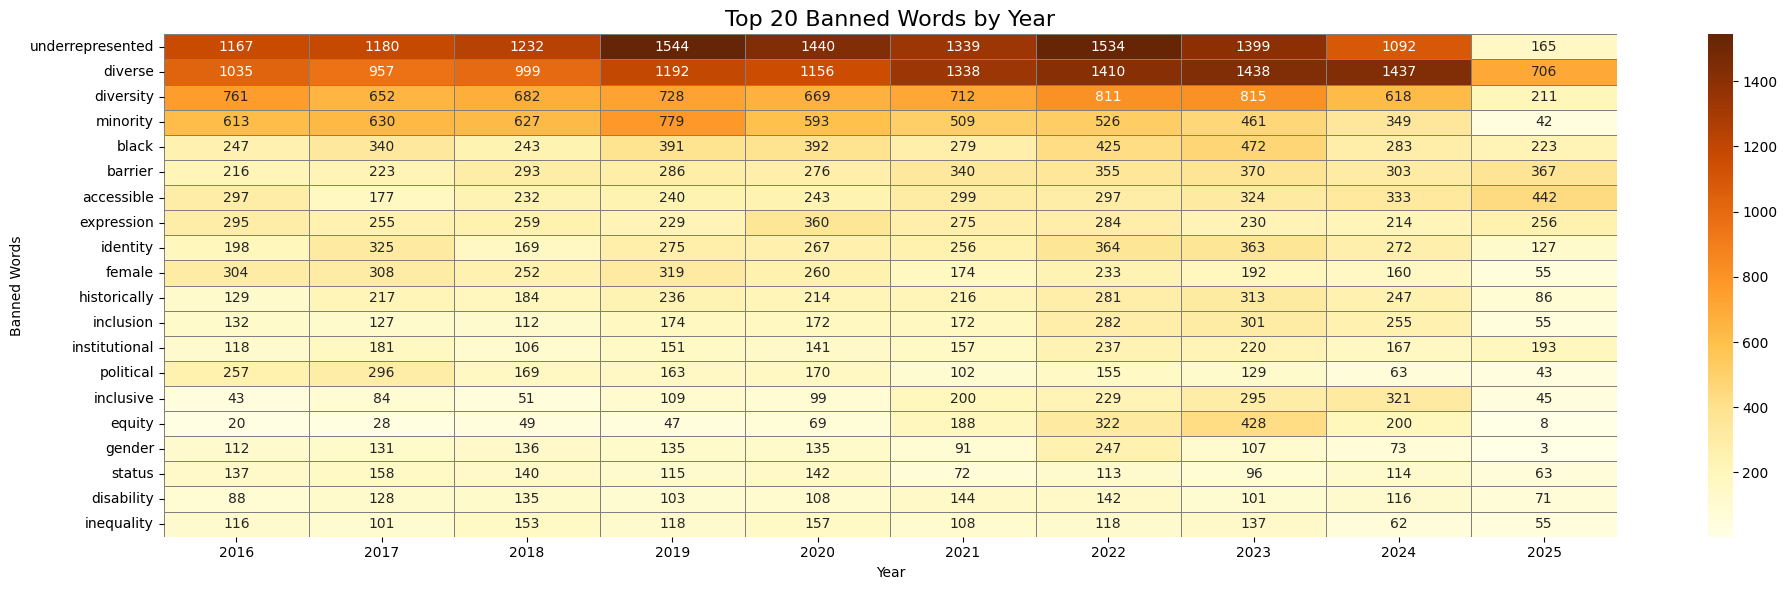

In [8]:
# Get the top 20 most frequent words (by total across all years)
top_20_words = pivot_table.sum(axis=1).sort_values(ascending=False).head(20).index

# Subset the pivot table to just those words
pivot_top20 = pivot_table.loc[top_20_words]

# Plot the heatmap
plt.figure(figsize=(20, 6))  # Width for years, height for 12 rows
sns.heatmap(pivot_top20, cmap="YlOrBr", linewidths=0.5, linecolor='gray', annot=True, fmt='d')
plt.title("Top 20 Banned Words by Year", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Banned Words")
plt.tight_layout()
plt.show()

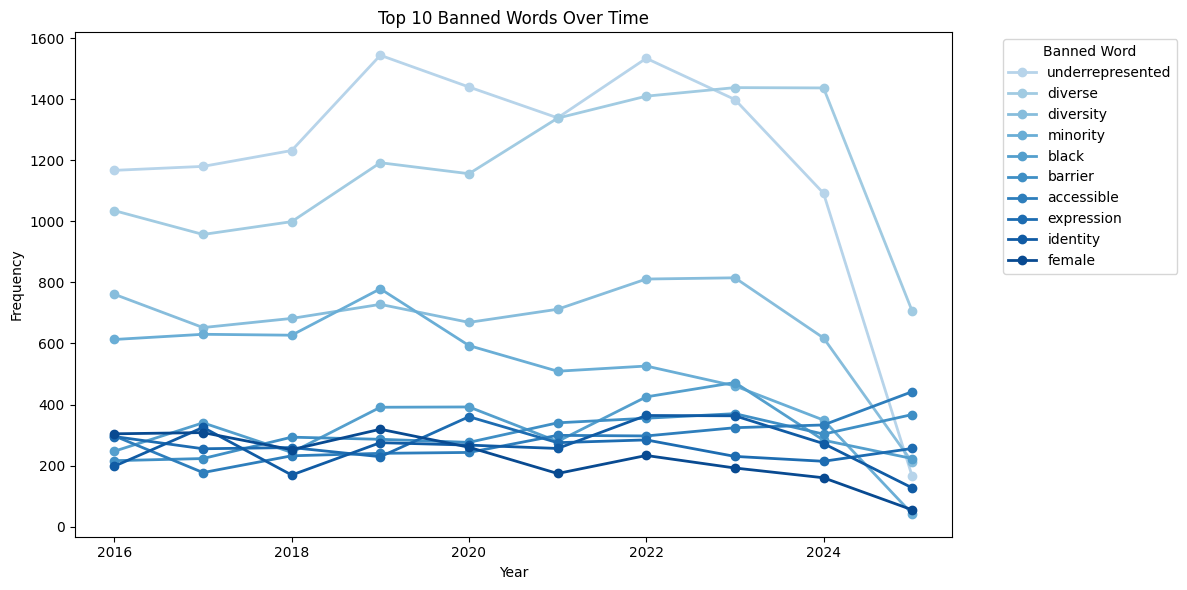

In [9]:
# Get top 10 most frequent banned words overall
top_words = pivot_table.sum(axis=1).sort_values(ascending=False).head(10).index
pivot_top = pivot_table.loc[top_words]

# Choose a colormap (can also try "coolwarm", "cividis", "Greys", "Purples", etc.)
cmap = plt.cm.Blues

# Generate N colors from the colormap
colors = cmap(np.linspace(0.3, 0.9, pivot_top.shape[0]))  # avoid very light or very dark

# Plot with custom colors
ax = pivot_top.T.plot(figsize=(12, 6), marker='o', color=colors, linewidth=2)

plt.title("Top 10 Banned Words Over Time")
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.legend(title="Banned Word", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Pre_New_Data

In [5]:
# Preprocess: lowercase the Abstracts for case-insensitive matching
awards_data['Abstract_clean'] = awards_data['Abstract'].str.lower()

# Group data by year
grouped = awards_data.groupby('Year')['Abstract_clean'].apply(lambda x: ' '.join(x)).reset_index()

# Create a DataFrame to store results
results = defaultdict(list)

# Count occurrences per banned word per year
for _, row in grouped.iterrows():
    year = row['Year']
    text = row['Abstract_clean']
    for word in banned_words:
        # Clean the word for regex (e.g. handle special characters like "+")
        word_escaped = re.escape(word.lower())
        count = len(re.findall(r'\b' + word_escaped + r'\b', text))
        results['Year'].append(year)
        results['Word'].append(word)
        results['Count'].append(count)

# Create final DataFrame
banned_counts_df = pd.DataFrame(results)

# Pivot the table for easier visualization (optional)
pivot_table = banned_counts_df.pivot(index='Word', columns='Year', values='Count').fillna(0).astype(int)

Year,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
Word,,,,,,,,,,
BIPOC,0,0,0,0,0,4,8,6,0,0
Black,28,48,32,53,69,98,96,71,65,29
DEI,0,0,0,2,0,37,21,28,8,0
DEIA,0,0,0,0,0,0,0,0,2,0
DEIAB,0,0,0,0,0,0,0,0,0,0


In [7]:
# Temporarily display all rows
pd.set_option('display.max_rows', None)

# View the full table
display(pivot_table)

Year,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
Word,,,,,,,,,,
BIPOC,0,0,0,0,0,4,8,6,0,0
Black,28,48,32,53,69,98,96,71,65,29
DEI,0,0,0,2,0,37,21,28,8,0
DEIA,0,0,0,0,0,0,0,0,2,0
DEIAB,0,0,0,0,0,0,0,0,0,0
DEIJ,0,0,0,0,0,0,0,4,0,0
GBV,0,0,0,0,0,0,0,0,0,0
Gulf of Mexico,5,9,28,12,12,5,7,12,0,0
LGBT,0,0,0,1,0,0,0,0,2,0


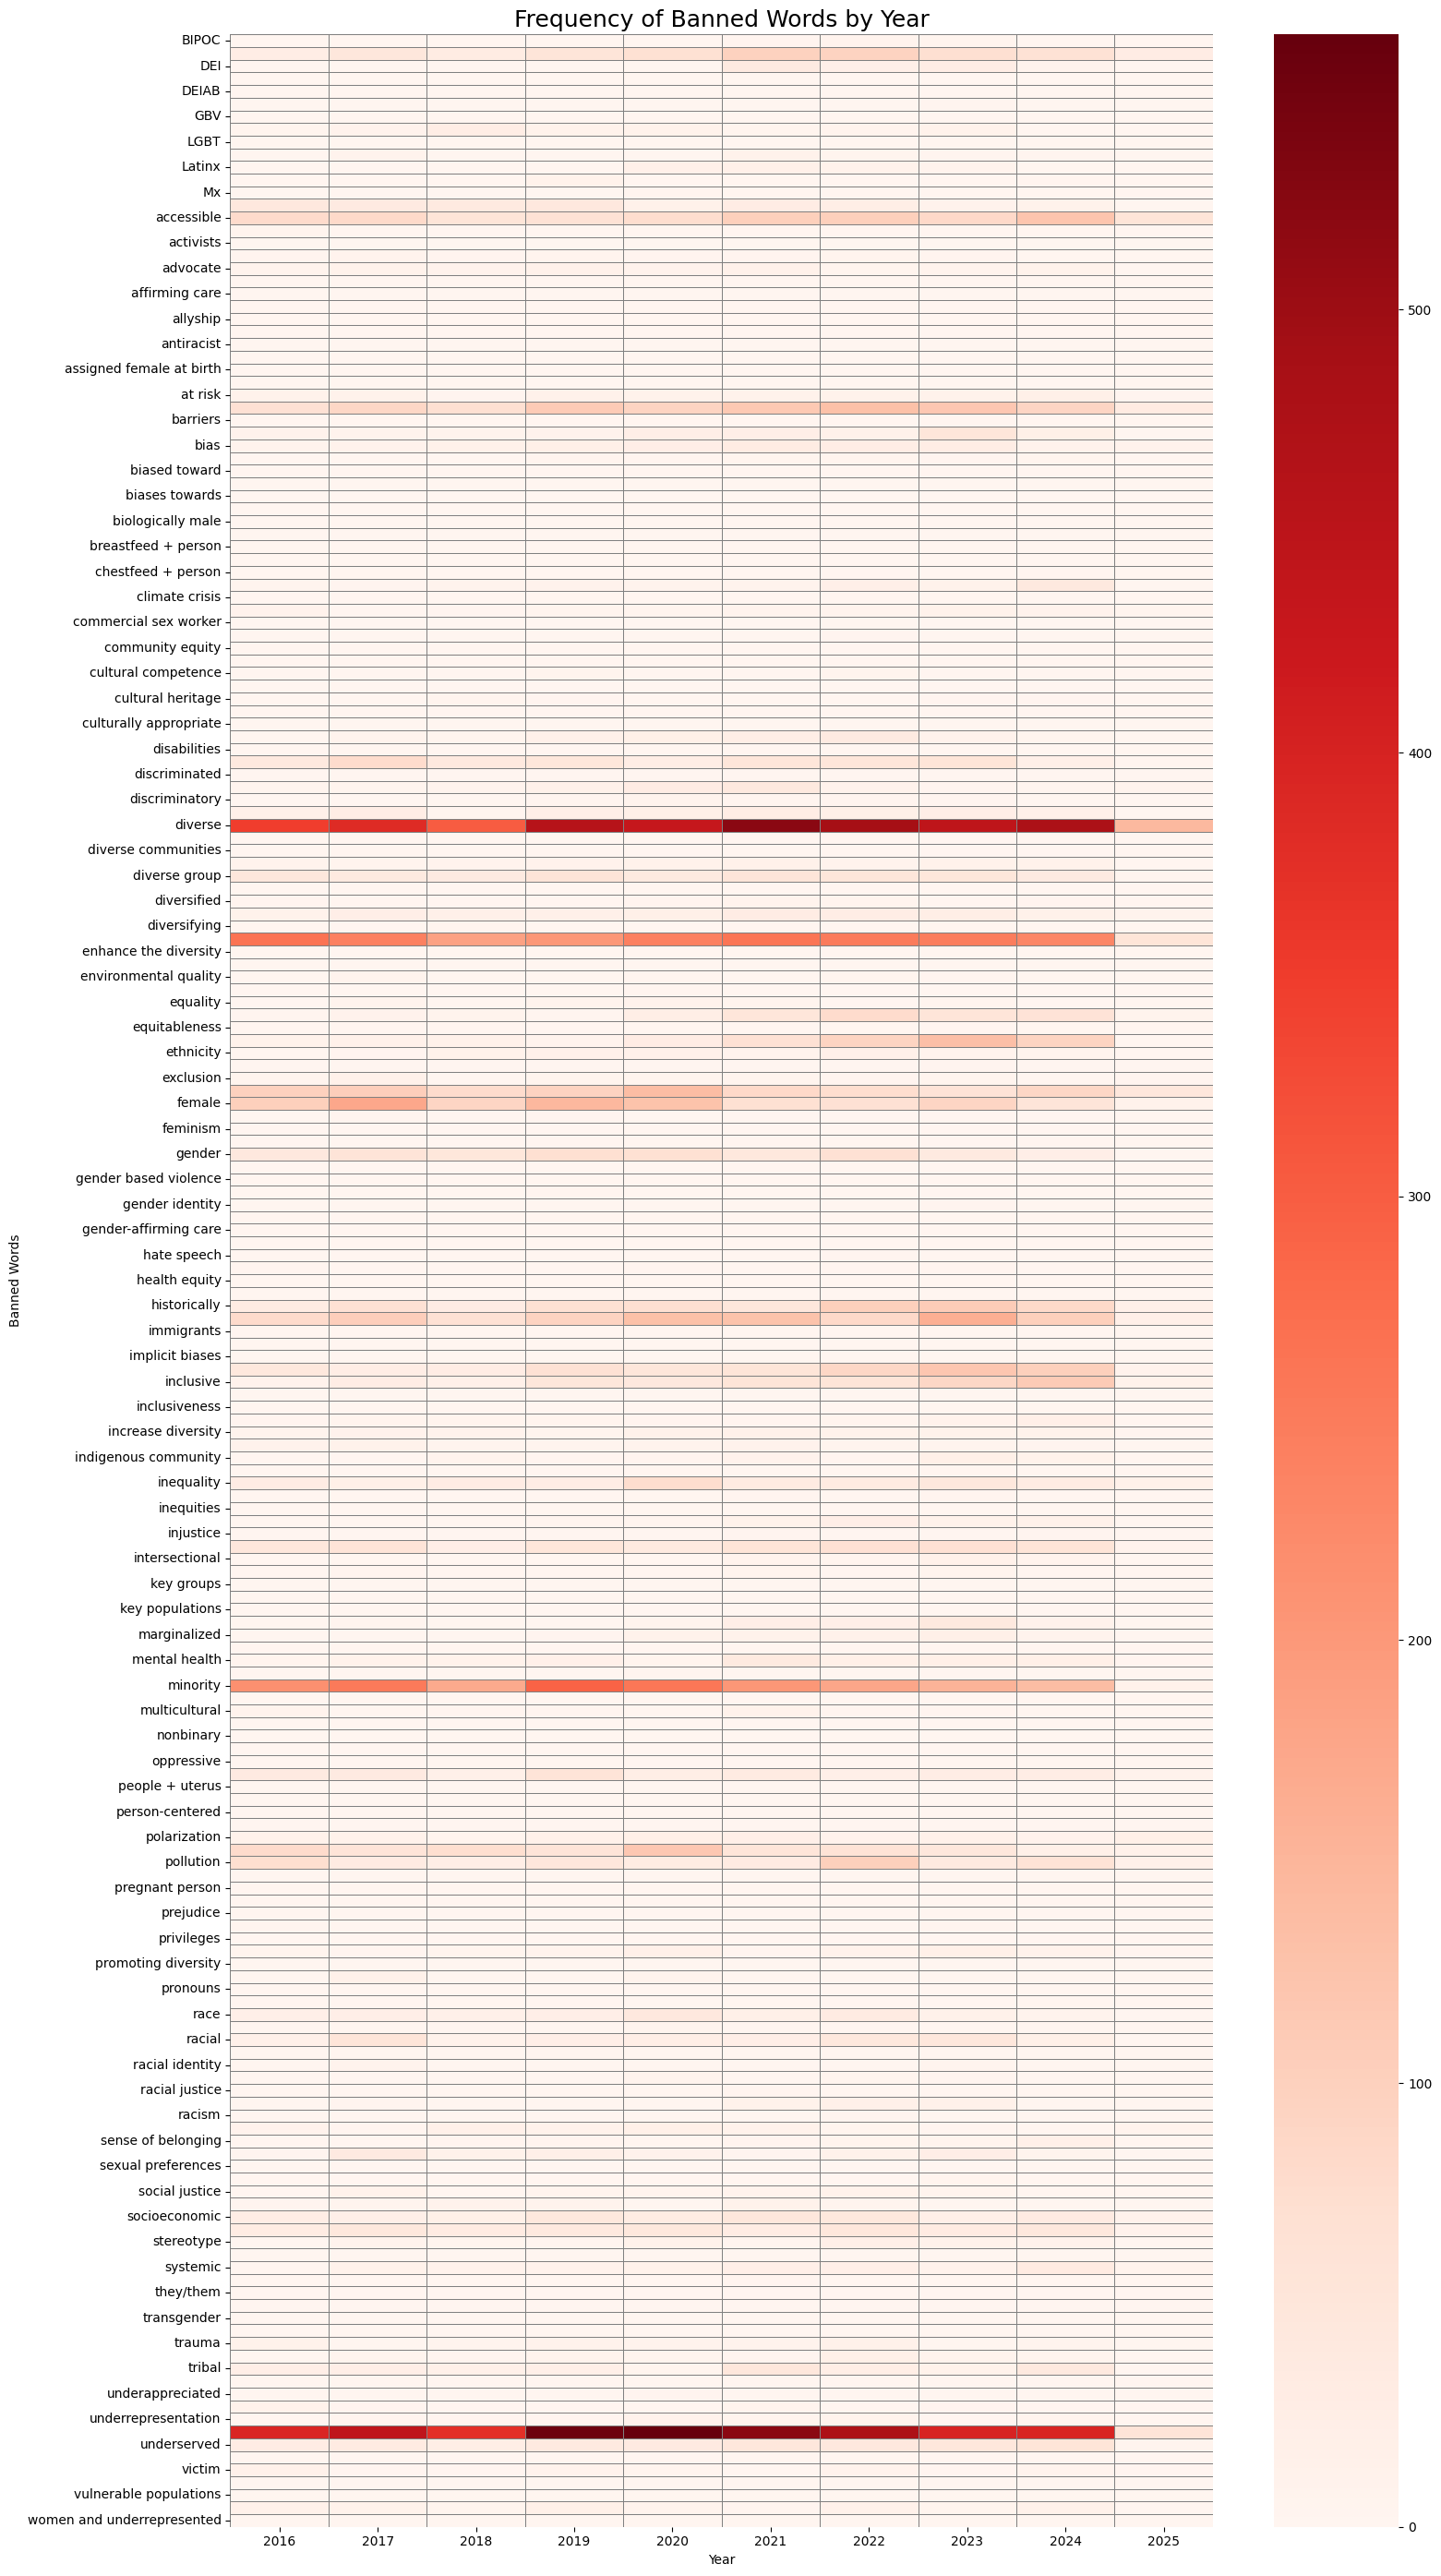

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 28))  # Adjust height for 197 rows
sns.heatmap(pivot_table, cmap="Reds", linewidths=0.5, linecolor='gray')

plt.title("Frequency of Banned Words by Year", fontsize=18)
plt.xlabel("Year")
plt.ylabel("Banned Words")
plt.tight_layout()
plt.show()

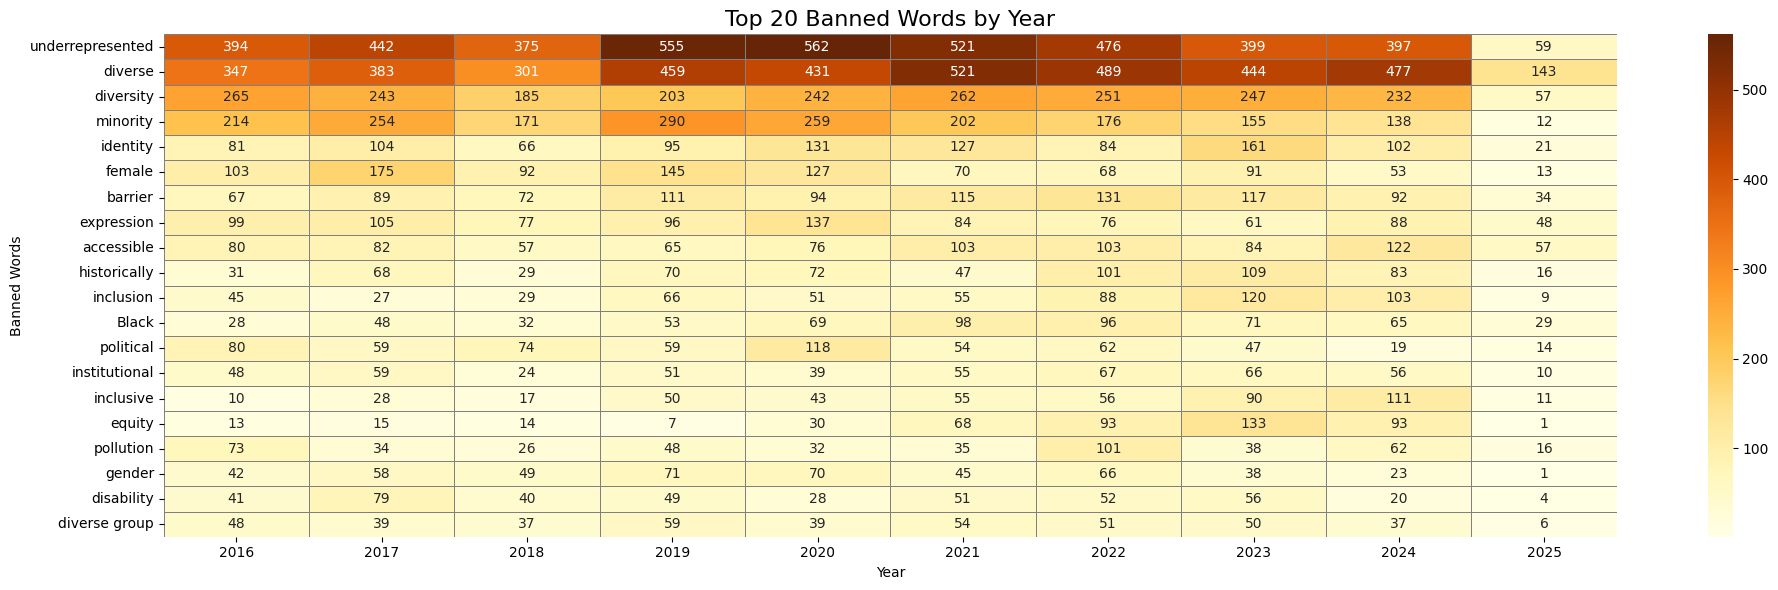

In [20]:

# Get the top 20 most frequent words (by total across all years)
top_20_words = pivot_table.sum(axis=1).sort_values(ascending=False).head(20).index

# Subset the pivot table to just those words
pivot_top20 = pivot_table.loc[top_20_words]

# Plot the heatmap
plt.figure(figsize=(20, 6))  # Width for years, height for 12 rows
sns.heatmap(pivot_top20, cmap="YlOrBr", linewidths=0.5, linecolor='gray', annot=True, fmt='d')
plt.title("Top 20 Banned Words by Year", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Banned Words")
plt.tight_layout()
plt.show()

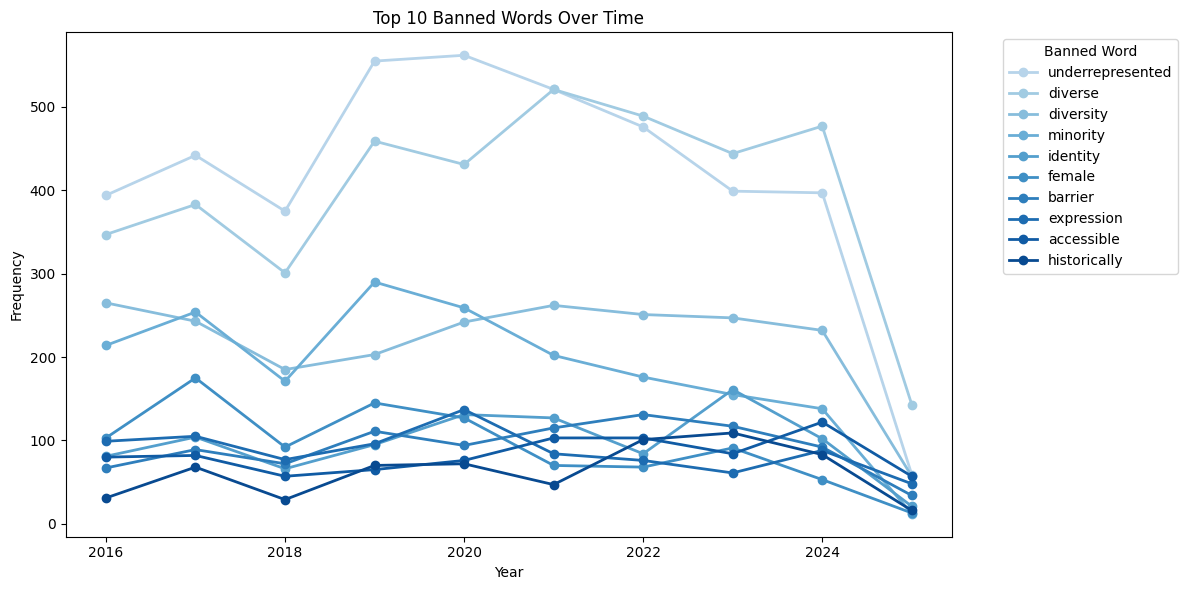

In [11]:
# Get top 10 most frequent banned words overall
top_words = pivot_table.sum(axis=1).sort_values(ascending=False).head(10).index
pivot_top = pivot_table.loc[top_words]

# Choose a colormap (can also try "coolwarm", "cividis", "Greys", "Purples", etc.)
cmap = plt.cm.Blues

# Generate N colors from the colormap
colors = cmap(np.linspace(0.3, 0.9, pivot_top.shape[0]))  # avoid very light or very dark

# Plot with custom colors
ax = pivot_top.T.plot(figsize=(12, 6), marker='o', color=colors, linewidth=2)

plt.title("Top 10 Banned Words Over Time")
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.legend(title="Banned Word", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

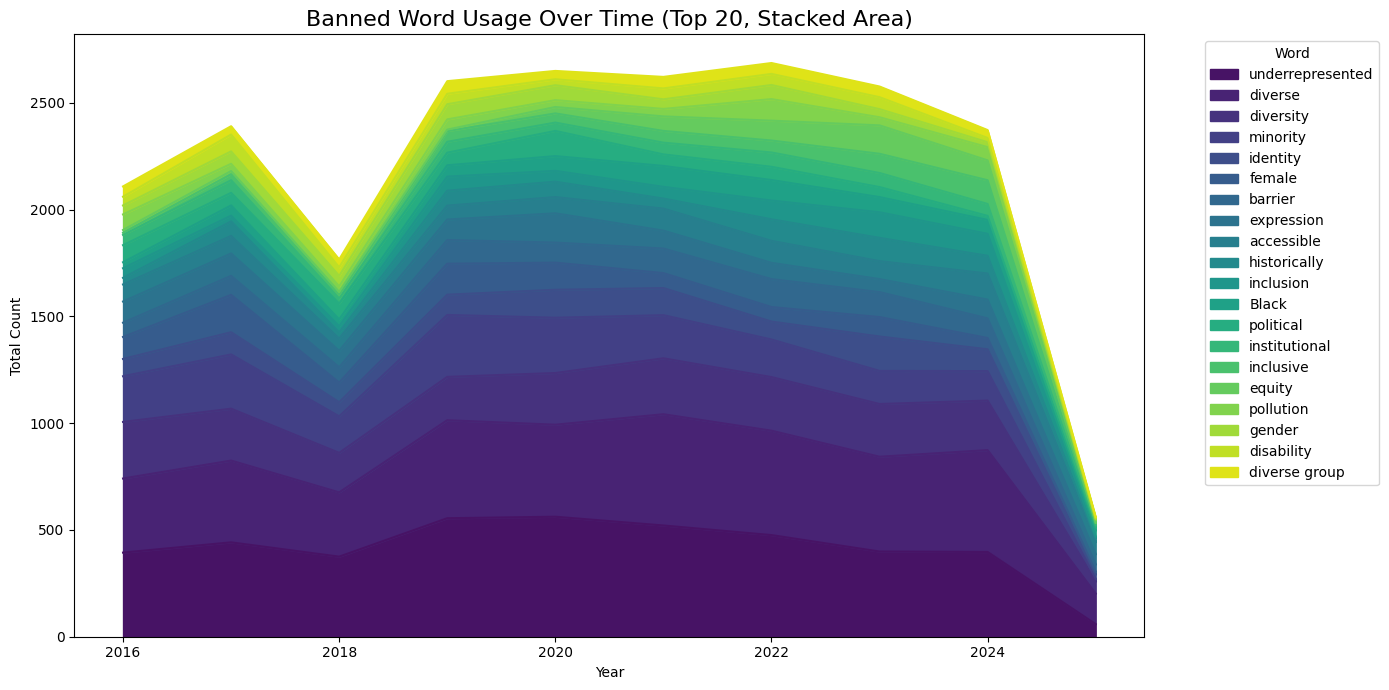

In [24]:
# Get top 20 banned words
top_20_words = pivot_table.sum(axis=1).sort_values(ascending=False).head(20).index
pivot_top20 = pivot_table.loc[top_20_words]

# Choose a cohesive colormap (viridis is smooth and colorblind-friendly)
colors = sns.color_palette("viridis", n_colors=20)

# Plot
pivot_top20.T.plot.area(figsize=(14, 7), color=colors)

plt.title("Banned Word Usage Over Time (Top 20, Stacked Area)", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Total Count")
plt.legend(title="Word", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()